# Setup

version 2: using UCI HAR Dataset

In [1]:
# import libraries
import os
import sys
import time
import pandas as pd
import numpy as np
from scipy import stats
from scipy.interpolate import CubicSpline
import torch.optim as optim
import torch.nn as nn
import torch
from torch.optim import Adam
from scipy.fftpack import fft, ifft
from scipy.stats import mode
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

## Hyperparameter

In [2]:
num_epochs = 200
batch_size = 64  # Set your batch size
learning_rate = 0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# set the seed
torch.manual_seed(420)
np.random.seed(420)


# Data Loading

## HHAR

In [4]:
# load data
# data = pd.read_csv('./ISWC21_data_plus_raw/hhar_data.csv', header=None)
data_hhar = pd.read_csv('./ISWC21_data_plus_raw/raw/hhar/Watch_accelerometer.csv')
#add header
# data.columns = ['subject_id', 'acc_x', 'acc_y', 'acc_z', 'activity']

# sort data by creation_time
data_hhar = data_hhar.sort_values(by=['Creation_Time'])
data_hhar

,Index,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
3179488,0,1424686740286,202601646000,4.018668,-7.155670,-3.341109,g,gear,gear_2,stand
3179489,1,1424686740287,202609390000,3.605069,-6.991668,-3.151368,g,gear,gear_2,stand
3179490,2,1424686740287,202619269000,3.038841,-6.546346,-3.436278,g,gear,gear_2,stand
3179491,3,1424686740287,202631619000,3.030461,-6.183026,-2.860472,g,gear,gear_2,stand
3179492,4,1424686740287,202639113000,3.354875,-6.126762,-2.382231,g,gear,gear_2,stand
...,...,...,...,...,...,...,...,...,...,...
2457915,459441,1424789460608,300643618732647,7.858872,3.448090,7.490219,e,lgwatch,lgwatch_1,bike
2457916,459442,1424789460612,300643623676495,7.478012,3.455231,6.997482,e,lgwatch,lgwatch_1,bike
2457917,459443,1424789460618,300643628711895,7.516098,2.324554,6.661850,e,lgwatch,lgwatch_1,bike
2457918,459444,1424789460622,300643633625225,6.811508,2.072235,6.885605,e,lgwatch,lgwatch_1,bike


In [5]:
# print number of unique subjects
print(data_hhar['User'].nunique())

9


### Data Preprocessed

In [6]:
# drop columns
data_hhar = data_hhar.drop(columns=['Index', 'Arrival_Time', 'Creation_Time', 'Model', 'Device'])
data_hhar

,x,y,z,User,gt
3179488,4.018668,-7.155670,-3.341109,g,stand
3179489,3.605069,-6.991668,-3.151368,g,stand
3179490,3.038841,-6.546346,-3.436278,g,stand
3179491,3.030461,-6.183026,-2.860472,g,stand
3179492,3.354875,-6.126762,-2.382231,g,stand
...,...,...,...,...,...
2457915,7.858872,3.448090,7.490219,e,bike
2457916,7.478012,3.455231,6.997482,e,bike
2457917,7.516098,2.324554,6.661850,e,bike
2457918,6.811508,2.072235,6.885605,e,bike


In [7]:
# replace user id with a number
user_dict = {
        'a': 0,
        'b': 1,
        'c': 2,
        'd': 3,
        'e': 4,
        'f': 5,
        'g': 6,
        'h': 7,
        'i': 8,
}
data_hhar = data_hhar.replace({"User": user_dict})

In [8]:
# replace activity with a number
activity_dict = {
        'bike': 1,
        'sit': 2,
        'stand': 3,
        'walk': 4,
        'stairsup': 5,
        'stairsdown': 6,
}
data_hhar = data_hhar.replace({"gt": activity_dict})

In [9]:
# print(data_hhar['gt'].value_counts())

In [10]:
# print(data_hhar['User'].value_counts())

In [11]:
data_hhar

,x,y,z,User,gt
3179488,4.018668,-7.155670,-3.341109,6,3.0
3179489,3.605069,-6.991668,-3.151368,6,3.0
3179490,3.038841,-6.546346,-3.436278,6,3.0
3179491,3.030461,-6.183026,-2.860472,6,3.0
3179492,3.354875,-6.126762,-2.382231,6,3.0
...,...,...,...,...,...
2457915,7.858872,3.448090,7.490219,4,1.0
2457916,7.478012,3.455231,6.997482,4,1.0
2457917,7.516098,2.324554,6.661850,4,1.0
2457918,6.811508,2.072235,6.885605,4,1.0


In [12]:
# resample data to 50 hz from 100 hz
data_hhar = data_hhar.iloc[::2, :]

In [13]:
# reorder columns
data_hhar = data_hhar[['User', 'x', 'y', 'z', 'gt']]

In [14]:
# rename the columns name
data_hhar.columns = ['subject_id', 'acc_x', 'acc_y', 'acc_z', 'activity']

In [15]:
data_hhar

,subject_id,acc_x,acc_y,acc_z,activity
3179488,6,4.018668,-7.155670,-3.341109,3.0
3179490,6,3.038841,-6.546346,-3.436278,3.0
3179492,6,3.354875,-6.126762,-2.382231,3.0
3179494,6,2.688689,-5.518635,-1.930924,3.0
3179498,6,0.672172,-4.964377,-1.953669,3.0
...,...,...,...,...,...
2457910,4,6.751999,1.558075,7.064133,1.0
2457912,4,7.835068,2.555450,8.770859,1.0
2457914,4,8.118332,3.052948,8.444748,1.0
2457916,4,7.478012,3.455231,6.997482,1.0


In [16]:
# check for missing values
data_hhar.isnull().sum()

subject_id         0
acc_x              0
acc_y              0
acc_z              0
activity      260235
dtype: int64

In [17]:
# drop missing values
data_hhar = data_hhar.dropna()

In [18]:
print(data_hhar['subject_id'].unique())

[6 5 7 3 2 1 0 4 8]


## RealWorld

In [19]:
# load data without header
data_rwhar = pd.read_csv('./ISWC21_data_plus_raw/rwhar_data.csv', header=None)
# add header
data_rwhar.columns = ['subject_id', 'acc_x', 'acc_y', 'acc_z', 'activity']
data_rwhar

,subject_id,acc_x,acc_y,acc_z,activity
0,0,-9.57434,-2.02733,1.34506,climbing_up
1,0,-9.56479,-1.99597,1.39345,climbing_up
2,0,-9.55122,-1.98445,1.41139,climbing_up
3,0,-9.51335,-1.97557,1.42615,climbing_up
4,0,-9.52959,-1.98187,1.45395,climbing_up
...,...,...,...,...,...
3200798,14,-9.28186,-2.45740,-1.88879,lying
3200799,14,-9.28955,-2.59154,-1.90494,lying
3200800,14,-9.31358,-2.62135,-1.90950,lying
3200801,14,-9.26154,-2.64308,-1.93750,lying


In [20]:
# print count of unique subjects
print(data_rwhar['subject_id'].nunique())

15


In [21]:
# print count of unique activities
print(data_rwhar['activity'].nunique())

8


### Data Preprocessed

In [22]:
#check for missing values
data_rwhar.isnull().sum()

subject_id    0
acc_x         0
acc_y         0
acc_z         0
activity      0
dtype: int64

In [23]:
data_rwhar['subject_id'] = data_rwhar['subject_id'] + 9

In [24]:
print(data_rwhar['subject_id'].unique())

[ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [25]:
# replace activity with a number
activity_dict = {
        'climbing_down': 6,
        'climbing_up': 5,
        'jumping': 7,
        'lying': 8,
        'running': 9,
        'sitting': 2,
        'standing': 3,
        'walking': 4,
}
data_rwhar = data_rwhar.replace({"activity": activity_dict})

In [26]:
print(data_rwhar['activity'].value_counts())

activity
9    522013
4    482938
8    479455
2    478761
3    473147
5    371180
6    320302
7     73007
Name: count, dtype: int64


In [27]:
print(data_rwhar['subject_id'].value_counts())

subject_id
13    245822
16    243823
11    227821
17    224449
23    222116
19    220262
21    218636
14    215920
9     214659
20    212453
18    210260
12    207492
15    189243
22    179282
10    168565
Name: count, dtype: int64


In [28]:
data_rwhar

,subject_id,acc_x,acc_y,acc_z,activity
0,9,-9.57434,-2.02733,1.34506,5
1,9,-9.56479,-1.99597,1.39345,5
2,9,-9.55122,-1.98445,1.41139,5
3,9,-9.51335,-1.97557,1.42615,5
4,9,-9.52959,-1.98187,1.45395,5
...,...,...,...,...,...
3200798,23,-9.28186,-2.45740,-1.88879,8
3200799,23,-9.28955,-2.59154,-1.90494,8
3200800,23,-9.31358,-2.62135,-1.90950,8
3200801,23,-9.26154,-2.64308,-1.93750,8


## UCI

In [29]:
#load dataset without header
data_uci = pd.read_csv('./UCI HAR Dataset/uci_har.csv')
data_uci

,subject_id,acc_x,acc_y,acc_z,activity
0,1,1.012817,-0.123217,0.102934,STANDING
1,1,1.022833,-0.126876,0.105687,STANDING
2,1,1.022028,-0.124004,0.102102,STANDING
3,1,1.017877,-0.124928,0.106553,STANDING
4,1,1.023680,-0.125767,0.102814,STANDING
...,...,...,...,...,...
1318267,24,0.908386,-0.423054,-0.092933,WALKING_UPSTAIRS
1318268,24,0.898984,-0.392272,-0.063138,WALKING_UPSTAIRS
1318269,24,0.918862,-0.351680,-0.072539,WALKING_UPSTAIRS
1318270,24,0.949475,-0.267526,-0.050975,WALKING_UPSTAIRS


### Data Preprocessed

In [30]:
# drop activity with 'null_class'
data_uci = data_uci[data_uci['activity'] != 'null_class']

In [31]:
data_uci

,subject_id,acc_x,acc_y,acc_z,activity
0,1,1.012817,-0.123217,0.102934,STANDING
1,1,1.022833,-0.126876,0.105687,STANDING
2,1,1.022028,-0.124004,0.102102,STANDING
3,1,1.017877,-0.124928,0.106553,STANDING
4,1,1.023680,-0.125767,0.102814,STANDING
...,...,...,...,...,...
1318267,24,0.908386,-0.423054,-0.092933,WALKING_UPSTAIRS
1318268,24,0.898984,-0.392272,-0.063138,WALKING_UPSTAIRS
1318269,24,0.918862,-0.351680,-0.072539,WALKING_UPSTAIRS
1318270,24,0.949475,-0.267526,-0.050975,WALKING_UPSTAIRS


In [32]:
# check for missing values
data_uci.isnull().sum()

subject_id    0
acc_x         0
acc_y         0
acc_z         0
activity      0
dtype: int64

In [33]:
# print count of unique subjects
print(data_uci['subject_id'].nunique())

30


In [34]:
# print count of unique activities
print(data_uci['activity'].nunique())

6


In [35]:
data_uci['subject_id'].unique()

array([ 1,  3,  5,  6,  7,  8, 11, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26,
       27, 28, 29, 30,  2,  4,  9, 10, 12, 13, 18, 20, 24], dtype=int64)

In [36]:
# change subject_id number
data_uci['subject_id'] = data_uci['subject_id'] + 23

In [37]:
print(data_uci['subject_id'].unique())

[24 26 28 29 30 31 34 37 38 39 40 42 44 45 46 48 49 50 51 52 53 25 27 32
 33 35 36 41 43 47]


In [38]:
data_uci['activity'].value_counts()

activity
LAYING                248832
STANDING              243968
SITTING               227456
WALKING               220416
WALKING_UPSTAIRS      197632
WALKING_DOWNSTAIRS    179968
Name: count, dtype: int64

In [39]:
# replace activity with a number
activity_dict = {
        'walking': 4,
        'walking_upstairs': 5,
        'walking_downstairs': 6,
        'sitting': 2,
        'standing': 3,
        'lying': 8,
        'stand-to-sit': 10,
        'sit-to-stand': 11,
        'sit-to-lie': 12,
        'lie-to-sit': 13,
        'stand-to-lie': 14,
        'lie-to-stand': 15,
        'LAYING': 8,
        'STANDING': 3,
        'SITTING': 2,
        'WALKING': 4,
        'WALKING_UPSTAIRS': 5,
        'WALKING_DOWNSTAIRS': 6,
}
data_uci = data_uci.replace({"activity": activity_dict})

In [40]:
print(data_uci['activity'].unique())

[3 2 8 4 6 5]


In [41]:
data_uci['activity'].value_counts()

activity
8    248832
3    243968
2    227456
4    220416
5    197632
6    179968
Name: count, dtype: int64

## Data Merging

In [42]:
# merge all datasets
data = pd.concat([data_hhar, data_rwhar, data_uci], ignore_index=True)
data

,subject_id,acc_x,acc_y,acc_z,activity
0,6,4.018668,-7.155670,-3.341109,3.0
1,6,3.038841,-6.546346,-3.436278,3.0
2,6,3.354875,-6.126762,-2.382231,3.0
3,6,2.688689,-5.518635,-1.930924,3.0
4,6,0.672172,-4.964377,-1.953669,3.0
...,...,...,...,...,...
6029316,47,0.908386,-0.423054,-0.092933,5.0
6029317,47,0.898984,-0.392272,-0.063138,5.0
6029318,47,0.918862,-0.351680,-0.072539,5.0
6029319,47,0.949475,-0.267526,-0.050975,5.0


In [43]:
#check for missing values
data.isnull().sum()

subject_id    0
acc_x         0
acc_y         0
acc_z         0
activity      0
dtype: int64

In [44]:
# check for unique subjects
print(data['subject_id'].nunique())

54


In [45]:
# print all of the unique subjects and sort them from smallest to largest
print(np.sort(data['subject_id'].unique()))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53]


In [46]:
# check for unique activities
print(data['activity'].nunique())

9


In [47]:
# print all of the unique activities and sort them from smallest to largest
print(np.sort(data['activity'].unique()))

[1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [48]:
# print the count of each activity
print(data['activity'].value_counts())

activity
4.0    981454
3.0    943149
2.0    918231
5.0    804358
6.0    740432
8.0    728287
9.0    522013
1.0    318390
7.0     73007
Name: count, dtype: int64


In [49]:
print(data['subject_id'].value_counts())

subject_id
4     250308
13    245822
16    243823
5     240547
11    227821
2     224969
17    224449
0     223778
23    222116
19    220262
21    218636
14    215920
9     214659
20    212453
1     212280
18    210260
12    207492
3     200172
15    189243
22    179282
10    168565
7      62399
6      59116
48     52352
44     52224
49     50176
53     49024
51     48896
47     48768
50     48128
46     47616
40     47104
39     46848
41     46592
42     46080
43     45312
24     44416
52     44032
26     43648
38     41984
36     41856
29     41600
37     41344
45     41088
35     40960
27     40576
34     40448
30     39424
28     38656
25     38656
33     37632
32     36864
8      36677
31     35968
Name: count, dtype: int64


# Data Preprocess

In [50]:
# # channel-wise z-normalization
# data['acc_x'] = (data['acc_x'] - data['acc_x'].mean()) / data['acc_x'].std()
# data['acc_y'] = (data['acc_y'] - data['acc_y'].mean()) / data['acc_y'].std()
# data['acc_z'] = (data['acc_z'] - data['acc_z'].mean()) / data['acc_z'].std()

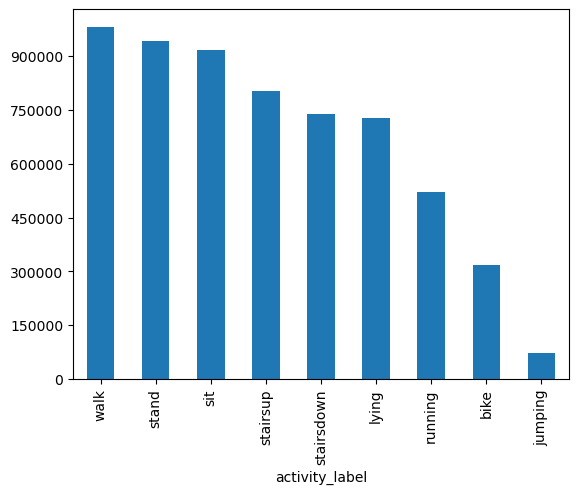

In [51]:
# label dictionary
label_dict = {
        1: 'bike',
        2: 'sit',
        3: 'stand',
        4: 'walk',
        5: 'stairsup',
        6: 'stairsdown',
        7: 'jumping',
        8: 'lying',
        9: 'running',
        10: 'stand-to-sit',
        11: 'sit-to-stand',
        12: 'sit-to-lie',
        13: 'lie-to-sit',
        14: 'stand-to-lie',
        15: 'lie-to-stand',
}

# visualize the label distribution using label dictionary with y axis use integer
data['activity_label'] = data['activity'].map(label_dict)
ax = data['activity_label'].value_counts().plot(kind='bar')

# Setting the y-axis to display only integer values
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

<Axes: xlabel='subject_id'>

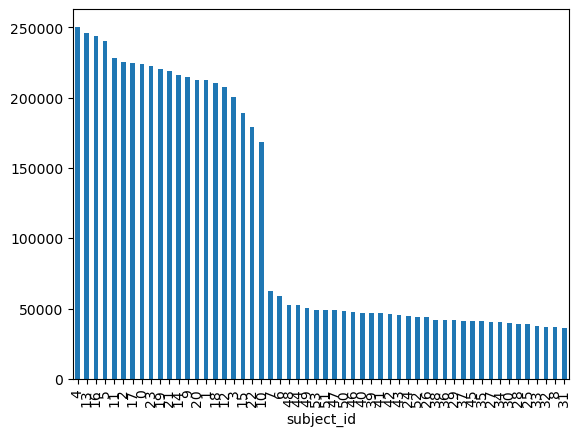

In [52]:
# visualize the subject distribution
data['subject_id'].value_counts().plot(kind='bar')

In [53]:
#drop activity_label
data = data.drop(columns=['activity_label'])

In [54]:
data

,subject_id,acc_x,acc_y,acc_z,activity
0,6,4.018668,-7.155670,-3.341109,3.0
1,6,3.038841,-6.546346,-3.436278,3.0
2,6,3.354875,-6.126762,-2.382231,3.0
3,6,2.688689,-5.518635,-1.930924,3.0
4,6,0.672172,-4.964377,-1.953669,3.0
...,...,...,...,...,...
6029316,47,0.908386,-0.423054,-0.092933,5.0
6029317,47,0.898984,-0.392272,-0.063138,5.0
6029318,47,0.918862,-0.351680,-0.072539,5.0
6029319,47,0.949475,-0.267526,-0.050975,5.0


### Remove Uncommon Label

In [55]:
# # remove rows with uncommon activities
# data = data[data['activity'] != 10]
# data = data[data['activity'] != 11]
# data = data[data['activity'] != 12]
# data = data[data['activity'] != 13]
# data = data[data['activity'] != 14]
# data = data[data['activity'] != 15]

# data

<Axes: xlabel='subject_id'>

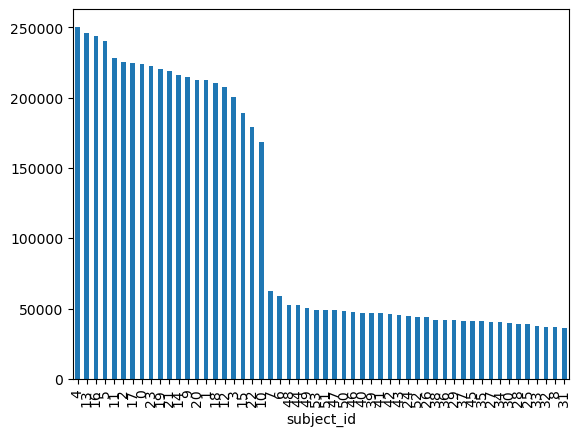

In [56]:
# visualize the subject distribution
data['subject_id'].value_counts().plot(kind='bar')

<Axes: xlabel='activity_label'>

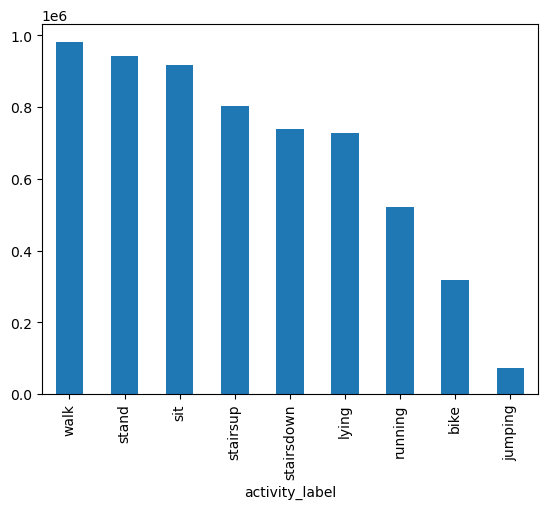

In [57]:
# label dictionary
label_dict = {
        1: 'bike',
        2: 'sit',
        3: 'stand',
        4: 'walk',
        5: 'stairsup',
        6: 'stairsdown',
        7: 'jumping',
        8: 'lying',
        9: 'running',
        10: 'stand-to-sit',
        11: 'sit-to-stand',
        12: 'sit-to-lie',
        13: 'lie-to-sit',
        14: 'stand-to-lie',
        15: 'lie-to-stand',
}

# visualize the label distribution using label dictionary
data['activity_label'] = data['activity'].map(label_dict)
data['activity_label'].value_counts().plot(kind='bar')

In [58]:
#drop activity_label
data = data.drop(columns=['activity_label'])

In [59]:
# check for unique activities
print(data['activity'].nunique())

9


In [60]:
data['activity'] = data['activity'] - 1

In [61]:
# check for unique subjects
print(data['subject_id'].nunique())

54


In [62]:
data

,subject_id,acc_x,acc_y,acc_z,activity
0,6,4.018668,-7.155670,-3.341109,2.0
1,6,3.038841,-6.546346,-3.436278,2.0
2,6,3.354875,-6.126762,-2.382231,2.0
3,6,2.688689,-5.518635,-1.930924,2.0
4,6,0.672172,-4.964377,-1.953669,2.0
...,...,...,...,...,...
6029316,47,0.908386,-0.423054,-0.092933,4.0
6029317,47,0.898984,-0.392272,-0.063138,4.0
6029318,47,0.918862,-0.351680,-0.072539,4.0
6029319,47,0.949475,-0.267526,-0.050975,4.0


In [63]:
data['activity'].unique()

array([2., 1., 3., 5., 4., 0., 8., 6., 7.])

In [64]:
# z-normalization of acc_x, acc_y, and acc_z
data['acc_x'] = (data['acc_x'] - data['acc_x'].mean()) / data['acc_x'].std()
data['acc_y'] = (data['acc_y'] - data['acc_y'].mean()) / data['acc_y'].std()
data['acc_z'] = (data['acc_z'] - data['acc_z'].mean()) / data['acc_z'].std()

## Partitioned the Data for Train and Test

In [65]:
# disabiling the warnings
import warnings
warnings.filterwarnings("ignore")

In [66]:
# data_test = {}
# data_labelled_train = {}
# data_unlabelled_train = {}

# #split the data for each subject
# for subject in np.sort(data['subject_id'].unique()):
#     subject_data = data[data['subject_id'] == subject]
#     # Shuffle the subject data
#     subject_data = subject_data.sample(frac=1).reset_index(drop=True)

#     # drop the subject_id column
#     subject_data = subject_data.drop(columns=['subject_id'])

#     # Split the subject data into 80% training and 20% testing
#     train, test = np.split(subject_data, [int(0.8 * len(subject_data))])

#     # Within the train data, further split into 20% labelled and 80% unlabelled
#     labelled_train, unlabelled_train = np.split(train, [int(0.2 * len(train))])

#     data_test[subject] = test
#     data_labelled_train[subject] = labelled_train
#     data_unlabelled_train[subject] = unlabelled_train

# # verify the split
# for subject in np.sort(data['subject_id'].unique()):
#     print('Subject:', subject)
#     print('Test:', data_test[subject].shape)
#     print('Labelled Train:', data_labelled_train[subject].shape)
#     print('Unlabelled Train:', data_unlabelled_train[subject].shape)

In [67]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

data_test = {}
data_labelled_train = {}
data_unlabelled_train = {}

# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for subject in np.sort(data['subject_id'].unique()):
    subject_data = data[data['subject_id'] == subject]
    labels = subject_data['activity'].values  # Assuming 'label' is your class label column

    # Drop the subject_id column
    subject_data = subject_data.drop(columns=['subject_id'])
    
    # Perform stratified split for train and test
    for train_index, test_index in sss.split(subject_data, labels):
        train_data, test_data = subject_data.iloc[train_index], subject_data.iloc[test_index]
        train_labels = labels[train_index]
        
        # Further split train data into labelled and unlabelled in a stratified manner
        sss_inner = StratifiedShuffleSplit(n_splits=1, test_size=0.8, random_state=42)
        for labelled_index, unlabelled_index in sss_inner.split(train_data, train_labels):
            labelled_train_data, unlabelled_train_data = train_data.iloc[labelled_index], train_data.iloc[unlabelled_index]
    
    # Store splits
    data_test[subject] = test_data
    data_labelled_train[subject] = labelled_train_data
    data_unlabelled_train[subject] = unlabelled_train_data

# Verify the split
for subject in np.sort(data['subject_id'].unique()):
    print('Subject:', subject)
    print('Test:', data_test[subject].shape)
    print('Labelled Train:', data_labelled_train[subject].shape)
    print('Unlabelled Train:', data_unlabelled_train[subject].shape)

Subject: 0
Test: (44756, 4)
Labelled Train: (35804, 4)
Unlabelled Train: (143218, 4)
Subject: 1
Test: (42456, 4)
Labelled Train: (33964, 4)
Unlabelled Train: (135860, 4)
Subject: 2
Test: (44994, 4)
Labelled Train: (35995, 4)
Unlabelled Train: (143980, 4)
Subject: 3
Test: (40035, 4)
Labelled Train: (32027, 4)
Unlabelled Train: (128110, 4)
Subject: 4
Test: (50062, 4)
Labelled Train: (40049, 4)
Unlabelled Train: (160197, 4)
Subject: 5
Test: (48110, 4)
Labelled Train: (38487, 4)
Unlabelled Train: (153950, 4)
Subject: 6
Test: (11824, 4)
Labelled Train: (9458, 4)
Unlabelled Train: (37834, 4)
Subject: 7
Test: (12480, 4)
Labelled Train: (9983, 4)
Unlabelled Train: (39936, 4)
Subject: 8
Test: (7336, 4)
Labelled Train: (5868, 4)
Unlabelled Train: (23473, 4)
Subject: 9
Test: (42932, 4)
Labelled Train: (34345, 4)
Unlabelled Train: (137382, 4)
Subject: 10
Test: (33713, 4)
Labelled Train: (26970, 4)
Unlabelled Train: (107882, 4)
Subject: 11
Test: (45565, 4)
Labelled Train: (36451, 4)
Unlabelled Trai

## Channel-Wise Z-Normalization

In [68]:
# def z_normalize_using_combined_stats(labelled_df, unlabelled_df, test_df, features=['acc_x', 'acc_y', 'acc_z']):
#     # Combine labelled and unlabelled data to calculate statistics
#     combined_df = pd.concat([labelled_df, unlabelled_df])
    
#     # Calculate mean and std for each feature
#     stats = {feature: (combined_df[feature].mean(), combined_df[feature].std()) for feature in features}
    
#     # Function to apply normalization
#     def apply_normalization(df):
#         for feature in features:
#             mean, std = stats[feature]
#             df[feature] = (df[feature] - mean) / std
#         return df

#     # Normalize labelled, unlabelled, and test data using these statistics
#     labelled_df = apply_normalization(labelled_df)
#     unlabelled_df = apply_normalization(unlabelled_df)
#     test_df = apply_normalization(test_df)

#     return labelled_df, unlabelled_df, test_df

# # Assuming you have dictionaries: data_labelled_train, data_unlabelled_train, and data_test
# # Iterate over each client and apply the normalization
# for subject in np.sort(data['subject_id'].unique()):
#     data_labelled_train[subject], data_unlabelled_train[subject], data_test[subject] = z_normalize_using_combined_stats(
#         data_labelled_train[subject],
#         data_unlabelled_train[subject],
#         data_test[subject]
#     )

## Windowing the Data

In [69]:
def sliding_window_samples(data, samples_per_window, overlap_ratio):
    """
    Return a sliding window measured in number of samples over a data array along with the mode label for each window.

    :param data: input array, can be numpy or pandas dataframe
    :param samples_per_window: window length as number of samples
    :param overlap_ratio: overlap is meant as percentage and should be an integer value
    :return: tuple of windows, indices, and labels
    """
    windows = []
    indices = []
    labels = []
    curr = 0
    win_len = int(samples_per_window)
    if overlap_ratio is not None:
        overlapping_elements = int((overlap_ratio / 100) * win_len)
        if overlapping_elements >= win_len:
            print('Number of overlapping elements exceeds window size.')
            return
    while curr < len(data) - win_len:
        window = data[curr:curr + win_len]
        windows.append(window.iloc[:, :-1])  # Exclude the last column which is the label
        indices.append([curr, curr + win_len])
        
        # Extract and compute the mode of the encoded labels for the current window
        window_labels = window['activity']
        mode_result = mode(window_labels)
        window_label = mode_result[0] if mode_result[0].size > 0 else mode_result
        labels.append(window_label)

        curr += win_len - overlapping_elements

    result_windows = np.array(windows)
    result_indices = np.array(indices)
    result_labels = np.array(labels)
    return result_windows, result_indices, result_labels

In [70]:
# windowing the data for each subject
sampling_rate = 50
time_window = 2.56
window_size = sampling_rate * time_window
overlap_ratio = 50 # 50% overlap

print('Window size:', window_size)
print('Overlap ratio %:', overlap_ratio)

windowed_labelled_train_x = []
windowed_unlabelled_train_x = []
windowed_test_x = []
windowed_labelled_train_y = []
windowed_unlabelled_train_y = []
windowed_test_y = []

# Iterate over each client and apply the sliding window
for subject in np.sort(data['subject_id'].unique()):
    labelled_train_data = data_labelled_train[subject]
    unlabelled_train_data = data_unlabelled_train[subject]
    test_data = data_test[subject]

    labelled_train_windows, _, labelled_train_labels = sliding_window_samples(labelled_train_data, window_size, overlap_ratio)
    unlabelled_train_windows, _, unlabelled_train_labels = sliding_window_samples(unlabelled_train_data, window_size, overlap_ratio)
    test_windows, _, test_labels = sliding_window_samples(test_data, window_size, overlap_ratio)

    windowed_labelled_train_x.append(labelled_train_windows)
    windowed_unlabelled_train_x.append(unlabelled_train_windows)
    windowed_test_x.append(test_windows)

    windowed_labelled_train_y.append(labelled_train_labels)
    windowed_unlabelled_train_y.append(unlabelled_train_labels)
    windowed_test_y.append(test_labels)

    print('Subject:', subject, 'Labelled Train Data shape:', labelled_train_windows.shape, 'Labelled Train Labels shape:', labelled_train_labels.shape)
    print('Subject:', subject, 'Unlabelled Train Data shape:', unlabelled_train_windows.shape, 'Unlabelled Train Labels shape:', unlabelled_train_labels.shape)
    print('Subject:', subject, 'Test Data shape:', test_windows.shape, 'Test Labels shape:', test_labels.shape)

Window size: 128.0
Overlap ratio %: 50


Subject: 0 Labelled Train Data shape: (558, 128, 3) Labelled Train Labels shape: (558,)
Subject: 0 Unlabelled Train Data shape: (2236, 128, 3) Unlabelled Train Labels shape: (2236,)
Subject: 0 Test Data shape: (698, 128, 3) Test Labels shape: (698,)
Subject: 1 Labelled Train Data shape: (529, 128, 3) Labelled Train Labels shape: (529,)
Subject: 1 Unlabelled Train Data shape: (2121, 128, 3) Unlabelled Train Labels shape: (2121,)
Subject: 1 Test Data shape: (662, 128, 3) Test Labels shape: (662,)
Subject: 2 Labelled Train Data shape: (561, 128, 3) Labelled Train Labels shape: (561,)
Subject: 2 Unlabelled Train Data shape: (2248, 128, 3) Unlabelled Train Labels shape: (2248,)
Subject: 2 Test Data shape: (702, 128, 3) Test Labels shape: (702,)
Subject: 3 Labelled Train Data shape: (499, 128, 3) Labelled Train Labels shape: (499,)
Subject: 3 Unlabelled Train Data shape: (2000, 128, 3) Unlabelled Train Labels shape: (2000,)
Subject: 3 Test Data shape: (624, 128, 3) Test Labels shape: (624,)


In [71]:
windowed_labelled_train_x[0]

array([[[-1.81013874, -0.20437405, -1.48254121],
        [-1.05198962,  1.08047474, -0.40231178],
        [-0.86086385, -0.37416316,  0.1989088 ],
        ...,
        [-0.7887623 , -0.56732777,  0.30874232],
        [-1.00471198, -0.09761059, -0.31252457],
        [-1.01501217, -0.14563785, -0.59553118]],

       [[-0.56286763,  0.23277471, -0.11441993],
        [-1.11162114,  0.87348998, -0.3158937 ],
        [-0.18104883, -0.03638902,  1.26961717],
        ...,
        [-0.75715126, -0.10130497,  1.308699  ],
        [-0.76745152,  0.28132976,  1.32150169],
        [-0.87258491,  0.27869089,  1.27433392]],

       [[-0.33803849, -2.00286766, -2.49639218],
        [-1.00400158, -0.05169442, -0.08072868],
        [-0.99050474, -0.06647204, -0.40079568],
        ...,
        [-0.5198908 ,  0.22327481, -0.55779696],
        [-0.70391296,  1.67316275,  0.79507571],
        [-1.55630693, -0.27388644, -0.31791517]],

       ...,

       [[-0.69446574, -0.59600026,  0.30110205],
        [-0

In [72]:
windowed_labelled_train_y[0]

array([3., 2., 2., 1., 0., 2., 2., 3., 2., 2., 3., 3., 3., 2., 2., 2., 2.,
       0., 2., 2., 3., 2., 2., 2., 3., 3., 0., 0., 0., 3., 2., 2., 2., 2.,
       2., 2., 1., 0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 2., 2., 0.,
       0., 3., 2., 2., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 2., 2., 0., 2., 2., 2., 0., 2., 2., 2., 3., 3., 2., 2., 0.,
       0., 3., 3., 2., 2., 3., 0., 2., 2., 2., 2., 0., 0., 3., 1., 3., 3.,
       3., 3., 0., 2., 2., 3., 3., 2., 3., 0., 2., 2., 2., 1., 0., 3., 2.,
       2., 3., 3., 2., 2., 2., 3., 3., 3., 0., 3., 2., 2., 2., 2., 2., 2.,
       4., 0., 0., 2., 0., 0., 2., 2., 2., 1., 2., 0., 0., 2., 2., 2., 2.,
       0., 0., 1., 3., 3., 3., 2., 0., 2., 2., 1., 0., 0., 2., 2., 2., 0.,
       0., 2., 2., 2., 3., 3., 2., 2., 2., 0., 0., 2., 2., 2., 2., 2., 2.,
       0., 0., 3., 2., 2., 0., 0., 0., 0., 2., 3., 0., 0., 0., 2., 2., 0.,
       0., 0., 2., 2., 2., 2., 2., 2., 3., 3., 3., 2., 1., 2., 2., 2., 3.,
       2., 3., 3., 2., 2.

In [73]:
# windowed_data_test = []
# windowed_labels_test = []
# windowed_data_labelled_train = []
# windowed_labels_labelled_train = []
# windowed_data_unlabelled_train = []
# windowed_labels_unlabelled_train = []

# # randomly split data into test and train for each subject
# for i in range(len(windowed_data)):
#     subject_windows = windowed_data[i]
#     subject_labels = windowed_labels[i]

#     # number of samples
#     n_samples = subject_windows.shape[0]

#     # generate indices for the whole dataset
#     indices = np.arange(n_samples)

#     # randomly shuffle the indices
#     np.random.shuffle(indices)

#     # Split indices for training (80%) and testing (20%)
#     train_indices = indices[:int(0.8 * n_samples)]
#     test_indices = indices[int(0.8 * n_samples):]

#     # Split the data into training and testing sets
#     x_train, y_train = subject_windows[train_indices], subject_labels[train_indices]
#     x_test, y_test = subject_windows[test_indices], subject_labels[test_indices]

#     # Split the training data into labelled and unlabelled sets (20% labelled, 80% unlabelled)
#     n_train_samples = x_train.shape[0]
#     n_labelled_samples = int(0.2 * n_train_samples)
#     labelled_indices = np.random.choice(n_train_samples, n_labelled_samples, replace=False)
#     unlabelled_indices = np.array([i for i in range(n_train_samples) if i not in labelled_indices])

#     x_labelled_train, y_labelled_train = x_train[labelled_indices], y_train[labelled_indices]
#     x_unlabelled_train, y_unlabelled_train = x_train[unlabelled_indices], y_train[unlabelled_indices]

#     windowed_data_test.append(x_test)
#     windowed_labels_test.append(y_test)
#     windowed_data_labelled_train.append(x_labelled_train)
#     windowed_labels_labelled_train.append(y_labelled_train)
#     windowed_data_unlabelled_train.append(x_unlabelled_train)
#     windowed_labels_unlabelled_train.append(y_unlabelled_train)

#     # print the shapes of the data
#     print('Subject:', i, 'Original Data:', subject_windows.shape, 'Original Label:', len(subject_labels))
#     print('Subject:', i, 'Train data shape:', x_train.shape, 'Test data shape:', x_test.shape)
#     print('Subject:', i, 'Labelled Train data shape:', x_labelled_train.shape, 'Unlabelled Train data shape:', x_unlabelled_train.shape)
#     print('*' * 50)


# Saved the FL Data

In [74]:
# save all data to local directory with the data for each subject in one folder

# create a directory to save the data
if not os.path.exists('FL_Data/windowed_data_filtered_w_UCI'):
    os.makedirs('FL_Data/windowed_data_filtered_w_UCI')

# save the data
for i in range(len(windowed_labelled_train_x)):
    subject = i
    subject_dir = 'FL_Data/windowed_data_filtered_w_UCI/subject_' + str(subject)
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)
    np.save(subject_dir + '/windowed_labelled_train_x.npy', windowed_labelled_train_x[i])
    np.save(subject_dir + '/windowed_unlabelled_train_x.npy', windowed_unlabelled_train_x[i])
    np.save(subject_dir + '/windowed_test_x.npy', windowed_test_x[i])
    np.save(subject_dir + '/windowed_labelled_train_y.npy', windowed_labelled_train_y[i])
    np.save(subject_dir + '/windowed_unlabelled_train_y.npy', windowed_unlabelled_train_y[i])
    np.save(subject_dir + '/windowed_test_y.npy', windowed_test_y[i])

In [75]:
# validate the saved data for each subject and check whether the shapes are correct with the original data
# compare the shape load data with the array of original data
for i in range(len(windowed_labelled_train_x)):
    subject = i
    subject_dir = 'FL_Data/windowed_data_filtered_w_UCI/subject_' + str(subject)
    print('Subject:', subject)
    print('Labelled Train Data:', np.array_equal(windowed_labelled_train_x[i], np.load(subject_dir + '/windowed_labelled_train_x.npy')))
    print('Unlabelled Train Data:', np.array_equal(windowed_unlabelled_train_x[i], np.load(subject_dir + '/windowed_unlabelled_train_x.npy')))
    print('Test Data:', np.array_equal(windowed_test_x[i], np.load(subject_dir + '/windowed_test_x.npy')))
    print('Labelled Train Labels:', np.array_equal(windowed_labelled_train_y[i], np.load(subject_dir + '/windowed_labelled_train_y.npy')))
    print('Unlabelled Train Labels:', np.array_equal(windowed_unlabelled_train_y[i], np.load(subject_dir + '/windowed_unlabelled_train_y.npy')))
    print('Test Labels:', np.array_equal(windowed_test_y[i], np.load(subject_dir + '/windowed_test_y.npy')))
    print('*' * 50)

Subject: 0
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
**************************************************
Subject: 1
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
**************************************************
Subject: 2
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
**************************************************
Subject: 3
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
**************************************************
Subject: 4
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
***********

Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
**************************************************
Subject: 6
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
**************************************************
Subject: 7
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
**************************************************
Subject: 8
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
**************************************************
Subject: 9
Labelled Train Data: True
Unlabelled Train Data: True
Test Data: True
Labelled Train Labels: True
Unlabelled Train Labels: True
Test Labels: True
************************************************